# Data Merging

## Author: Yue 'Luna' Huang

### Nov 16, 2017

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt

import gdal, osr

from scipy.interpolate import RegularGridInterpolator

from tqdm import tqdm, tqdm_notebook

In [2]:
assert sys.version_info[0] >= 3, "Python 3 or a more recent version is required."

## Class and Function

In [3]:
class Raster:
    
    import numpy as np
    from scipy.interpolate import RegularGridInterpolator
    
    def __init__(self,
                 latUpper=56 - 0.1/2, longLower=72 + 0.1/2,
                 latStep=0.1, longStep=0.1,
                 latN=400, longN=650):
        """ Record latitude and longitude information on the uniform grid.
        Default to our bounding box in China.
        
        :param
            latUpper, longLower:
                float, the upper left corner of the bounding box
            latStep, longStep:
                float, the spatial resolution in degrees, both should be positive
            latN, longN:
                int, total number of observations in each dimension
        """
        
        # initialized values
        self.latUpper = latUpper
        self.longLower = longLower
        self.latStep = latStep
        self.longStep = longStep
        self.latN = latN
        self.longN = longN
        self.latLower = latUpper - latStep * (latN - 1)
        self.longUpper = longLower + longStep * (longN - 1)
        # compute coordinates
        self.lat = np.linspace(self.latLower, self.latUpper, self.latN)
        self.long = np.linspace(self.longLower, self.longUpper, self.longN)
        # initialize empty array
        self.values = np.empty((self.longN, self.latN))
        self.values.fill(np.nan)
        
    def fill(self, array):
        """ Fill in the raster with the array.
        
        :param
            array:
                2 dimensional ndarray, the first element of the array should be
                the lower left corner of the map (smallest long and lat)
                the array is long (dimension 0) by lat (dimension 1)
        """
        
        # check dimension
        assert array.shape == (self.longN, self.latN), "Dimension Mismatch."
        # copy array
        self.values = array.copy()
    
    def find_neighbor_mean(self, points):
        """ Impute the closest observation contained in self raster.
        
        :param
            points:
                a two-dimensional ndarray with a pair of long, lat in each row
                interpolation will be based on self, output will be returned
        :return
            a one-dimensional ndarray with the interpolated points
        """
        
        # initialize output
        output = np.empty((points.shape[0]))
        output.fill(np.nan)
        
        # extract values from self array via direct indexing
        for i, point in enumerate(points):
            # find source index
            selfLongIndex = int(np.floor(
                (point[0] - self.longLower) / self.longStep))
            selfLatIndex = int(np.floor(
                (point[1] - self.latLower) / self.latStep))
            # impute value
            output[i] = np.nanmean(
                self.values[selfLongIndex:(selfLongIndex + 2), selfLatIndex:(selfLatIndex + 2)])
        return output
    
    def find_weighted_mean(self, kernel, points):
        """ Impute weighted mean contained in self raster.
        
        :param
            kernel:
                a two-dimensional ndarray, the spatial kernel
            points:
                a two-dimensional ndarray with a pair of long, lat in each row
                interpolation will be based on self, output will be returned
        :return
            a one-dimensional ndarray with the interpolated points
        """
        
        # initialize output
        output = np.empty((points.shape[0]))
        output.fill(np.nan)
        
        # extract values from self array via direct indexing
        for i, point in enumerate(points):
            # find source index
            selfLongIndex = int(np.floor(
                (point[0] - self.longLower) / self.longStep))
            selfLatIndex = int(np.floor(
                (point[1] - self.latLower) / self.latStep))
            longBand, latBand = kernel.shape
            longBand, latBand = int(longBand / 2), int(latBand / 2)
            cell = self.values[(selfLongIndex + 1 - longBand):(selfLongIndex + 1 + longBand),
                               (selfLatIndex + 1 - latBand):(selfLatIndex + 1 + latBand)]
            # impute value
            if np.isnan(cell[kernel != 0]).all():
                output[i] = np.nan
            else:
                kernel[np.isnan(cell)] = 0
                kernel = kernel / np.sum(kernel)
                output[i] = np.nansum(cell * kernel)
        return output
    
    def find_interpolated(self, points):
        """ Impute the interpolated values contained in self raster.
        
        :param
            points:
                a two-dimensional ndarray with a pair of long, lat in each row
                interpolation will be based on self, output will be returned
        :return
            a one-dimensional ndarray with the interpolated points
        """
        
        # extract values
        rgi = RegularGridInterpolator((self.long, self.lat), self.values)
        output = rgi(points)
        return output

## Extract CSVs from Rasters

### EVI

In [12]:
# define paths
monitor_coords_file = "../../data/processed/monitor/monitor_coords.csv"
raster_root = "../../data/processed/evi/"
output_root = "../../data/processed/evi_csv/"

In [13]:
monitor_coords = pd.read_csv(monitor_coords_file)
output = monitor_coords[['id']].copy()

In [14]:
points = monitor_coords[['long', 'lat']].values

In [15]:
raster_files = [f for f in os.listdir(raster_root) if f.endswith('.tif')]

In [16]:
# test
if False:
    raster_files = raster_files[0:3]

In [18]:
raster_parent = Raster()
for raster_file in tqdm(raster_files):
    # parse file name
    raster_info = raster_file.split('.')[0]
    date, dataset, variable = raster_info.split('_')
    # read in array
    raster = gdal.Open(os.path.join(raster_root, raster_file)).ReadAsArray()
    raster_parent.fill(raster)
    # generate output
    raster_output = raster_parent.find_interpolated(points).astype(np.float16)
    # reduce float bytes
    kwargs = {variable: raster_output, 'date': date}
    output.assign(**kwargs).to_csv(os.path.join(output_root, raster_info + '.csv'), index=False)

100%|██████████| 3/3 [00:00<00:00, 43.55it/s]


### O3

In [4]:
# define paths
monitor_coords_file = "../../data/processed/monitor/monitor_coords.csv"
raster_root = "../../data/processed/o3/"
output_root = "../../data/processed/o3_csv/"
# extract coords
monitor_coords = pd.read_csv(monitor_coords_file)
output = monitor_coords[['id']].copy()
points = monitor_coords[['long', 'lat']].values
# list files
raster_files = [f for f in os.listdir(raster_root) if f.endswith('.tif')]

In [5]:
# test
if False:
    raster_files = raster_files[0:3]

In [6]:
raster_parent = Raster()
for raster_file in tqdm_notebook(raster_files):
    # parse file name
    raster_info = raster_file.split('.')[0]
    date, dataset, variable = raster_info.split('_')
    # read in array
    raster = gdal.Open(os.path.join(raster_root, raster_file)).ReadAsArray()
    raster_parent.fill(raster)
    # generate output
    raster_output = raster_parent.find_interpolated(points).astype(np.float16)
    # reduce float bytes
    kwargs = {variable: raster_output, 'date': date}
    output.assign(**kwargs).to_csv(os.path.join(output_root, raster_info + '.csv'), index=False)

HBox(children=(IntProgress(value=0, max=4366), HTML(value='')))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice


### SO2

In [9]:
# define paths
monitor_coords_file = "../../data/processed/monitor/monitor_coords.csv"
raster_root = "../../data/omi_so2/"
output_root = "../../data/processed/so2_csv/"
# extract coords
monitor_coords = pd.read_csv(monitor_coords_file)
output = monitor_coords[['id']].copy()
points = monitor_coords[['long', 'lat']].values
# list files
raster_files = [f for f in os.listdir(raster_root) if f.endswith('.tif')]

In [10]:
# test
if False:
    raster_files = raster_files[0:3]

In [11]:
raster_parent = Raster()
for raster_file in tqdm_notebook(raster_files):
    # parse file name
    raster_info = raster_file.split('.')[0]
    date, dataset, variable = raster_info.split('_')
    # read in array
    raster = gdal.Open(os.path.join(raster_root, raster_file)).ReadAsArray()
    # censor
    raster[raster < -1e+10] = np.nan
    # check dimension
    if raster.shape == (400, 650):
        raster_parent.fill(raster.T)
    elif raster.shape == (650, 400):
        raster_parent.fill(raster)
    else:
        assert False
    # generate output
    raster_output = raster_parent.find_interpolated(points).astype(np.float16)
    # reduce float bytes
    kwargs = {variable: raster_output, 'date': date}
    output.assign(**kwargs).to_csv(os.path.join(output_root, raster_info + '.csv'), index=False)

HBox(children=(IntProgress(value=0, max=4365), HTML(value='')))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice


### MYDAOD

In [12]:
# define paths
monitor_coords_file = "../../data/processed/monitor/monitor_coords.csv"
raster_root = "../../data/MYDAOD/"
output_root = "../../data/processed/mydaod_csv/"
# extract coords
monitor_coords = pd.read_csv(monitor_coords_file)
output = monitor_coords[['id']].copy()
points = monitor_coords[['long', 'lat']].values
# list files
raster_files = [f for f in os.listdir(raster_root) if f.endswith('.tif')]

In [ ]:
# test
if False:
    raster_files = raster_files[0:3]

In [ ]:
raster_parent = Raster()
for raster_file in tqdm_notebook(raster_files):
    # parse file name
    raster_info = raster_file.split('.')[0]
    date, dataset, variable = raster_info.split('_')
    # read in array
    raster = gdal.Open(os.path.join(raster_root, raster_file)).ReadAsArray()
    # censor
    raster[raster < -1e+10] = np.nan
    # check dimension
    if raster.shape == (400, 650):
        raster_parent.fill(raster.T)
    elif raster.shape == (650, 400):
        raster_parent.fill(raster)
    else:
        assert False
    # generate output
    raster_output = raster_parent.find_interpolated(points).astype(np.float16)
    # reduce float bytes
    kwargs = {variable: raster_output, 'date': date}
    output.assign(**kwargs).to_csv(os.path.join(output_root, raster_info + '.csv'), index=False)

HBox(children=(IntProgress(value=0, max=4380), HTML(value='')))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice


### MODAOD

In [ ]:
# define paths
monitor_coords_file = "../../data/processed/monitor/monitor_coords.csv"
raster_root = "../../data/MODAOD/"
output_root = "../../data/processed/modaod_csv/"
# extract coords
monitor_coords = pd.read_csv(monitor_coords_file)
output = monitor_coords[['id']].copy()
points = monitor_coords[['long', 'lat']].values
# list files
raster_files = [f for f in os.listdir(raster_root) if f.endswith('.tif')]

In [ ]:
# test
if False:
    raster_files = raster_files[0:3]

In [ ]:
raster_parent = Raster()
for raster_file in tqdm_notebook(raster_files):
    # parse file name
    raster_info = raster_file.split('.')[0]
    date, dataset, variable = raster_info.split('_')
    # read in array
    raster = gdal.Open(os.path.join(raster_root, raster_file)).ReadAsArray()
    # censor
    raster[raster < -1e+10] = np.nan
    # check dimension
    if raster.shape == (400, 650):
        raster_parent.fill(raster.T)
    elif raster.shape == (650, 400):
        raster_parent.fill(raster)
    else:
        assert False
    # generate output
    raster_output = raster_parent.find_interpolated(points).astype(np.float16)
    # reduce float bytes
    kwargs = {variable: raster_output, 'date': date}
    output.assign(**kwargs).to_csv(os.path.join(output_root, raster_info + '.csv'), index=False)

### Kernel

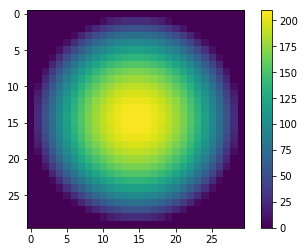

In [10]:
x = np.arange(0, 30)
y = np.arange(0, 30)
xx, yy = np.meshgrid(x, y)
k = (14.5 ** 2 - ((xx - 14.5)**2 + (yy - 14.5)**2))
k[k < 0] = 0
plt.imshow(k)
plt.colorbar()
plt.show()

In [8]:
# define paths
monitor_coords_file = "../../data/processed/monitor/monitor_coords.csv"
raster_root = "../../data/MODAOD/"
output_root = "../../data/processed/modaod_kernel_csv/"
# extract coords
monitor_coords = pd.read_csv(monitor_coords_file)
output = monitor_coords[['id']].copy()
points = monitor_coords[['long', 'lat']].values
# list files
raster_files = [f for f in os.listdir(raster_root) if f.endswith('.tif')]

In [9]:
# test
if True:
    raster_files = raster_files[0:3]

In [45]:
raster_parent = Raster()
for raster_file in tqdm_notebook(raster_files):
    # parse file name
    raster_info = raster_file.split('.')[0]
    date, dataset, variable = raster_info.split('_')
    # read in array
    raster = gdal.Open(os.path.join(raster_root, raster_file)).ReadAsArray()
    # censor
    raster[raster < -1e+10] = np.nan
    # check dimension
    if raster.shape == (400, 650):
        raster_parent.fill(raster.T)
    elif raster.shape == (650, 400):
        raster_parent.fill(raster)
    else:
        assert False
    # generate output
    raster_output = raster_parent.find_weighted_mean(kernel=k, points=points).astype(np.float16)
    # reduce float bytes
    kwargs = {variable: raster_output, 'date': date}
    output.assign(**kwargs).to_csv(os.path.join(output_root, raster_info + '.csv'), index=False)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))